# SVM on Amazon Dataset

In [56]:
#import libraries.....
import time
import sqlite3
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.plotly as py
import plotly.tools as tls
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize

from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_validate
import datetime
from sklearn.model_selection import StratifiedKFold
import sklearn.metrics

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import scipy as sp
from scipy import sparse
import tqdm
from prettytable import PrettyTable
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [57]:
# using the SQLite Table to read data.
# The below SQlite file consists of 60000 rows with Time based splitting and Summary column preprocessed[Feature Engineering].
con = sqlite3.connect('./final_tbs_cleansummary_text.sqlite')

final_tbs=pd.read_sql_query("""select * from Reviews""",con) # The table was preprocessed with time based splitting.
con.close()

final_tbs.head(5)

,level_0,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText,Cleaned_Summary
0,0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...,everi book educ
1,30,138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,positive,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,rememb see show air televis year ago child sis...,whole seri great way spend time child
2,424,417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,positive,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,beetlejuic well written movi everyth excel act...,entertainingl funni
3,330,346055,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,positive,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",twist rumplestiskin captur film star michael k...,modern day fairi tale
4,423,417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,positive,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,beetlejuic excel funni movi keaton hilari wack...,fantast


In [58]:
def partition(x):
    if x == "positive":
        return 1
    return 0

actualScore = final_tbs['Score']
positiveNegative = actualScore.map(partition) 
final_tbs['Score'] = positiveNegative

final_tbs.head(5)


,level_0,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText,Cleaned_Summary
0,0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...,everi book educ
1,30,138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,1,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,rememb see show air televis year ago child sis...,whole seri great way spend time child
2,424,417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,1,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,beetlejuic well written movi everyth excel act...,entertainingl funni
3,330,346055,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,1,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",twist rumplestiskin captur film star michael k...,modern day fairi tale
4,423,417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,1,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,beetlejuic excel funni movi keaton hilari wack...,fantast


In [59]:
#Since Summary column gives move details about what the text is, I joined both the features[Feature Engineering].
final_tbs['Summary_CleanedText'] = final_tbs[['Cleaned_Summary', 'CleanedText']].apply(lambda x: ' '.join(x), axis=1)

print(final_tbs['Summary_CleanedText'][0])

everi book educ witti littl book make son laugh loud recit car drive along alway sing refrain hes learn whale india droop love new word book introduc silli classic book will bet son still abl recit memori colleg


In [60]:
# To plot confusion matrix.
def plot_confusion_matrix(y_test, pred):
    C = confusion_matrix(y_test, pred)
    
    labels = [1,2]
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(10,4))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

In [61]:
# To print scores
def print_metrics_measure(pred,y_test,pred_train,y_1):
    
     # Plotting Confusion_Matrix
    plot_confusion_matrix(y_test, pred)
    
    # evaluate accuracy
    acc = accuracy_score(y_test, pred) * 100
    print('\nThe accuracy of the LR [Test data] for lambda: ',(acc))
    
    # Precision
    precision = metrics.precision_score(y_test, pred)*100
    print('\nThe precision of the LR [Test data] for lambda: ',(precision))
    
    # Recall
    recall = metrics.recall_score(y_test, pred)*100
    print('\nThe recall of the LR [Test data] for lambda: ',(recall))
    
    print("******"*20)
    
    #F1_Score on train data
    f1_score = metrics.f1_score(y_1, pred_train)*100
    print('\nThe F1_score of the LR [Train data] for lambda: ',(f1_score))
    
    #F1_Score
    f1_score = metrics.f1_score(y_test, pred)*100
    print('\nThe F1_score of the LR [Test data] for lambda: ',(f1_score))
    
    print("----"*20)

In [62]:
# 'C': [0.0001,0.001,0.01,0.1,1,10,100,1000], 'gamma': [0.0001,0.001,0.01,0.1,1,10,100,1000],

def grid_linear_svm(train_std_data,test_std_data,y_1,y_test):
    start=time.time()
    cv_scores = []
    tuned_parameters = [{'alpha': [0.0001,0.001,0.01,0.1,1,10,100,1000], "penalty":["l1","l2"]}]
    #k = StratifiedKFold(n_splits=5)
    grid_lr = GridSearchCV(SGDClassifier(loss='hinge',learning_rate='optimal'), tuned_parameters, scoring = 'f1', cv=5)
    grid_lr.fit(train_std_data,y_1)
    print("Best Estimator: ")
    model = grid_lr.best_estimator_
    print(model)
    print("******"*20)
    
    alpha = [0.0001,0.001,0.01,0.1,1,10,100,1000]
    
    if grid_lr.best_params_['penalty'] == 'l1':
        cv_scores = (grid_lr.cv_results_['mean_train_score'][::2])
    else:
        cv_scores = (grid_lr.cv_results_['mean_train_score'][1::2])
        
    plt.plot(alpha, cv_scores)
    
    for xy in zip(alpha, np.round(cv_scores,3)):
        plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
    
    plt.xlabel('Hyperparameters')
    plt.ylabel('cv_scores')
    plt.title("CV_SCORES of Trian")
    plt.grid()
    plt.show()


    #print("Best Hyperparameter is: ",grid_lr.best_params_['C'])
    
    if grid_lr.best_params_['penalty'] == 'l1':
        cv_scores = (grid_lr.cv_results_['mean_test_score'][::2])
    else:
        cv_scores = (grid_lr.cv_results_['mean_test_score'][1::2])

    for xy in zip(alpha, np.round(cv_scores,3)):
        plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
    
    plt.plot(alpha, cv_scores)
        
    plt.xlabel('Hyperparameters')
    plt.ylabel('cv_scores')
    plt.title("CV_SCORES of Test")
    plt.grid()
    plt.show()
    
    #print("Best Hyperparameter is: ",grid_lr.best_params_['C'])
    
    print("******"*20)
    
    pred_train = grid_lr.predict(train_std_data)
    pred = grid_lr.predict(test_std_data)
    
    print_metrics_measure(pred,y_test,pred_train,y_1)
    
    end=time.time()-start
    print(time.strftime("%H:%M:%S", time.gmtime(end)))
    return model

In [63]:
# 'C': [0.0001,0.001,0.01,0.1,1,10,100,1000], 'gamma': [0.0001,0.001,0.01,0.1,1,10,100,1000],

def random_RBF_svm(train_std_data,test_std_data,y_1,y_test):
    start=time.time()
    cv_scores = []
    tuned_parameters = {'C': [0.01,0.1,1,10,100], 'gamma': [0.01,0.1,1,10,100]}
    #k = StratifiedKFold(n_splits=5)
    random_lr = RandomizedSearchCV(SVC(kernel='rbf'), tuned_parameters, scoring = 'f1', cv=5)
    random_lr.fit(train_std_data,y_1)
    print("Best Estimator: ")
    model = random_lr.best_estimator_
    print(model)
    print("******"*20)  
    pred = random_lr.predict(test_std_data)
    
    print_metrics_measure(pred,y_test)
    
    end=time.time()-start
    print(time.strftime("%H:%M:%S", time.gmtime(end)))
    return model

In [64]:
# split the data set into train and test
y = np.array(final_tbs['Score'])

In [65]:
#Splitting whole data into Train,Cv,and Test datasets
# Using K-fold cross validation.
train_df, test_df, y_1, y_test = train_test_split(final_tbs, y, test_size=0.20, random_state=43,shuffle=False)

### BOW

In [66]:
#BoW
count_vect = CountVectorizer() #in scikit-learn

train_bows = count_vect.fit_transform(train_df['Summary_CleanedText'])
test_bows = count_vect.transform(test_df['Summary_CleanedText'])

Standard = StandardScaler(with_mean=False)

train_std_bow = Standard.fit_transform(train_bows)
test_std_bow = Standard.transform(test_bows)
#print(train_bows.shape)

Best Estimator: 
SGDClassifier(alpha=0.1, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)
************************************************************************************************************************


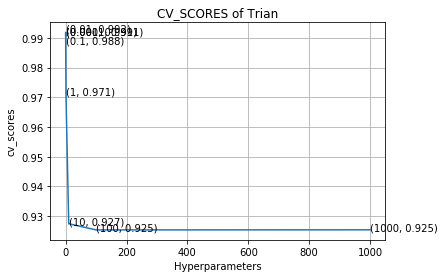

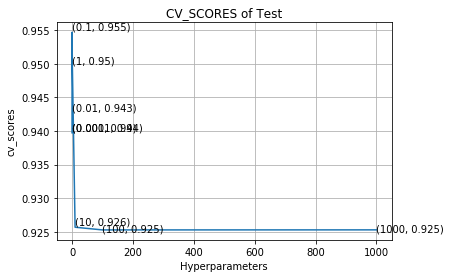

************************************************************************************************************************
-------------------- Confusion matrix --------------------


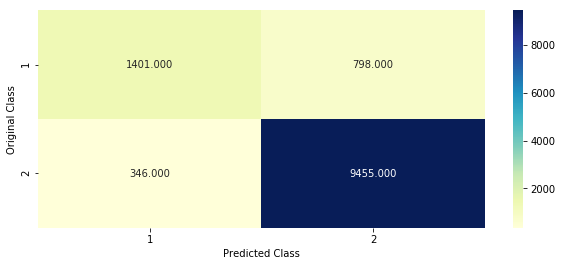


The accuracy of the LR [Test data] for lambda:  90.46666666666667

The precision of the LR [Test data] for lambda:  92.21691212328099

The recall of the LR [Test data] for lambda:  96.4697479848995
************************************************************************************************************************

The F1_score of the LR [Train data] for lambda:  98.63664160581315

The F1_score of the LR [Test data] for lambda:  94.2954024134836
--------------------------------------------------------------------------------
00:00:10


In [67]:
linear_grid_bow = grid_linear_svm(train_std_bow,test_std_bow,y_1,y_test)

In [68]:
#rbf_grid_bow = random_RBF_svm(train_std_bow,test_std_bow,y_1,y_test)

### Printing Top 100 Positive and Negative features.

In [69]:
def plot_wordcloud(text):
    # Create and generate a word cloud image:
    wordcloud = WordCloud(width = 1500, height = 600, 
                background_color ='white',  
                min_font_size = 10).generate(text) 
  
    # plot the WordCloud image                        
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
  
    plt.show()

In [70]:
# coef_  --> Coefficient of the  features in the decision function.

# To check top 100 features after pertubation test.

def show_most_informative_features(vectorizer, clf, n=100):
    positive_text = ' '
    negative_text = ' '
    feature_names = vectorizer.get_feature_names()
    #print((clf.coef_[0][1999]))
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    #print(coefs_with_fns[:-11:-1])
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    for (coef_1, fn_1),(coef_2, fn_2) in top:
        positive_text = positive_text + fn_2 + ' '
        negative_text = negative_text + fn_1 + ' '
    # To print positive words
    print("Positive Features: ")
    plot_wordcloud(positive_text)
    
    # To print negative words
    print("Negative Features: ")
    plot_wordcloud(negative_text)

Positive Features: 


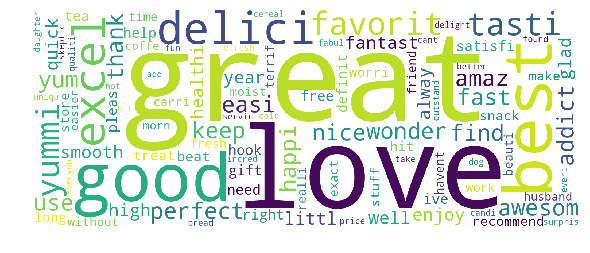

Negative Features: 


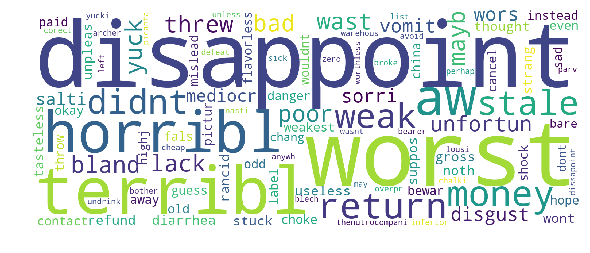

In [71]:
show_most_informative_features(count_vect, linear_grid_bow)

### TFIDF

In [72]:
tf_idf_vect = TfidfVectorizer()

train_tfidf = tf_idf_vect.fit_transform(train_df['Summary_CleanedText'])
test_tfidf = tf_idf_vect.transform(test_df['Summary_CleanedText'])

Standard = StandardScaler(with_mean=False)

train_std_tfidf = Standard.fit_transform(train_tfidf)
test_std_tfidf = Standard.transform(test_tfidf)


Best Estimator: 
SGDClassifier(alpha=0.1, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)
************************************************************************************************************************


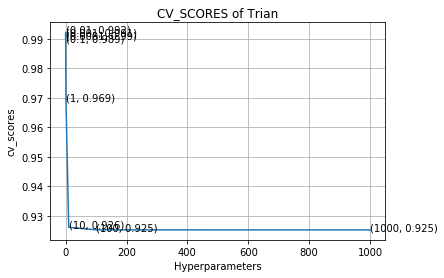

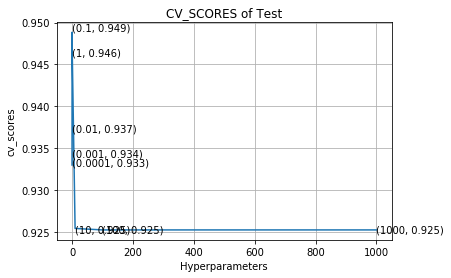

************************************************************************************************************************
-------------------- Confusion matrix --------------------


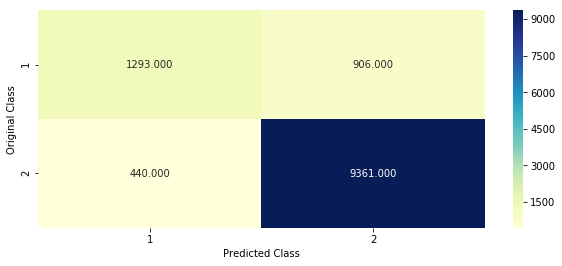


The accuracy of the LR [Test data] for lambda:  88.78333333333333

The precision of the LR [Test data] for lambda:  91.17561118145515

The recall of the LR [Test data] for lambda:  95.51066217732884
************************************************************************************************************************

The F1_score of the LR [Train data] for lambda:  98.72907290729073

The F1_score of the LR [Test data] for lambda:  93.29280446481961
--------------------------------------------------------------------------------
00:00:10


In [73]:
linear_grid_tfidf = grid_linear_svm(train_std_tfidf,test_std_tfidf,y_1,y_test)

In [74]:
#rbf_grid_tfidf = random_RBF_svm(train_std_tfidf,test_std_tfidf,y_1,y_test)

Positive Features: 


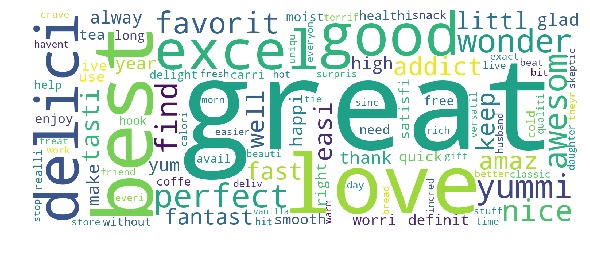

Negative Features: 


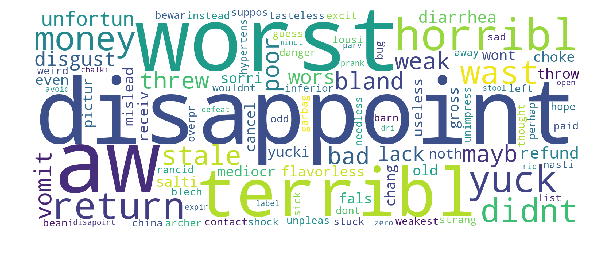

In [75]:
show_most_informative_features(tf_idf_vect, linear_grid_tfidf)

### AVG-W2V

In [76]:
# We have to train Word2Vec only by using train data.
def train_Word2Vec(list_of_sent):
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sent,min_count=5,size=50, workers=4)
    w2v_words = list(w2v_model.wv.vocab)
    return w2v_model,w2v_words

In [77]:

def avgw2v(list_of_sent,w2v_model,w2v_words):
    # average Word2Vec
    # compute average word2vec for each review.
    sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
    for sent in list_of_sent: # for each review/sentence
        sent_vec = np.zeros(50) # as word vectors are of zero length
        cnt_words =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_words:
                vec = w2v_model.wv[word]
                sent_vec += vec
                cnt_words += 1
        if cnt_words != 0:
            sent_vec /= cnt_words
        sent_vectors.append(sent_vec)
    print(len(sent_vectors))
    print(len(sent_vectors[0]))
    return sent_vectors


In [78]:
start=time.time()

# Train your own Word2Vec model using your own text corpus
i=0
#train_sent_vectors=[]
#cv_sent_vectors=[]
#test_sent_vectors=[]

list_of_sent=[]
for sent in train_df['Summary_CleanedText'].values:
    list_of_sent.append(sent.split())
    
w2v_model,w2v_words = train_Word2Vec(list_of_sent)
train_sent_vectors = avgw2v(list_of_sent,w2v_model,w2v_words)

list_of_sent=[]
for sent in test_df['Summary_CleanedText'].values:
    list_of_sent.append(sent.split())

test_sent_vectors = avgw2v(list_of_sent,w2v_model,w2v_words)
    
end=time.time()-start
print(time.strftime("%H:%M:%S", time.gmtime(end)))

48000
50
12000
50
00:01:17


In [79]:
Standard = StandardScaler(with_mean=False)

train_std_avg = Standard.fit_transform(train_sent_vectors)
test_std_avg = Standard.transform(test_sent_vectors)

Best Estimator: 
SGDClassifier(alpha=0.01, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)
************************************************************************************************************************


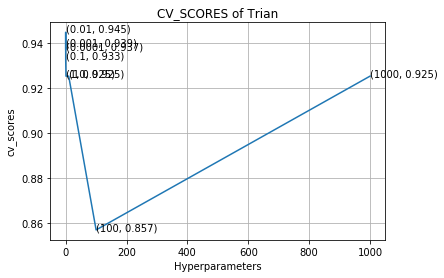

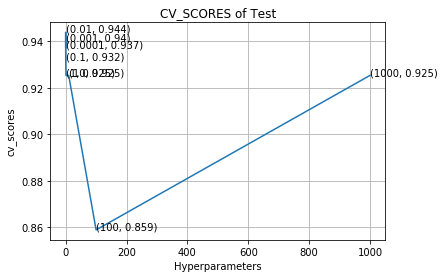

************************************************************************************************************************
-------------------- Confusion matrix --------------------


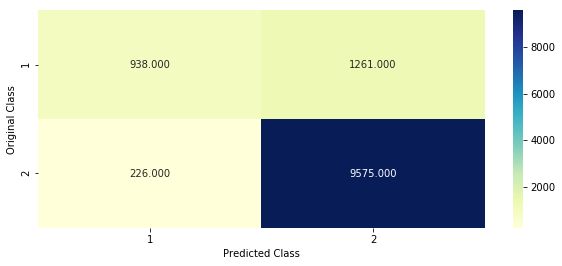


The accuracy of the LR [Test data] for lambda:  87.60833333333333

The precision of the LR [Test data] for lambda:  88.36286452565523

The recall of the LR [Test data] for lambda:  97.694112845628
************************************************************************************************************************

The F1_score of the LR [Train data] for lambda:  94.4882991499831

The F1_score of the LR [Test data] for lambda:  92.79449532393274
--------------------------------------------------------------------------------
00:00:11


In [80]:
linear_grid_avg = grid_linear_svm(train_std_avg,test_std_avg,y_1,y_test)

In [81]:
#rbf_grid_avg = random_RBF_svm(train_std_avg,test_std_avg,y_1,y_test)

### TFIDF-W2V

In [82]:
#Only for train data

def train_Word2Vec(list_of_sent):
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sent,min_count=5,size=50, workers=4)
    w2v_words = list(w2v_model.wv.vocab)
    return w2v_model,w2v_words

def compute_tfidf(list_of_sent,w2v_words,dictionary):
    for sent in list_of_sent:
        for word in sent:
            if word in w2v_words:
                 tf_idf_train_data = dictionary[word]*(sent.count(word)/len(sent)) # Computing tfidf value only with train data.
    return tf_idf_train_data

In [83]:
def tfidf_w2v(list_of_sent,w2v_model,w2v_words,tf_idf):
    # TF-IDF weighted Word2Vec
    #model = TfidfVectorizer()
    #tfidf_feat = model.get_feature_names() # tfidf words/col-names
    # final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

    tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
    row=0;
    for sent in list_of_sent: # for each review/sentence 
        sent_vec = np.zeros(50) # as word vectors are of zero length
        weight_sum =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_words:
                vec = w2v_model.wv[word]
                # tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
                # to reduce the computation we are 
                # dictionary[word] = idf value of word in whole courpus
                # sent.count(word) = tf valeus of word in this review
                #tf_idf = dictionary[word]*(sent.count(word)/len(sent))
                sent_vec += (vec * tf_idf)
                weight_sum += tf_idf
        if weight_sum != 0:
            sent_vec /= weight_sum
        tfidf_sent_vectors.append(sent_vec)
        row += 1
    return tfidf_sent_vectors

In [84]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]

model = TfidfVectorizer()
start=time.time()

# Train your own Word2Vec model using your own text corpus
i=0
list_of_sent=[]
for sent in train_df['Summary_CleanedText'].values:
    list_of_sent.append(sent.split())
                        
tf_idf_matrix = model.fit_transform(train_df['Summary_CleanedText'].values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

w2v_model,w2v_words = train_Word2Vec(list_of_sent)

tf_idf_train_data = compute_tfidf(list_of_sent,w2v_words,dictionary)

train_tfidf_w2v_vectors = tfidf_w2v(list_of_sent,w2v_model,w2v_words,tf_idf_train_data)

list_of_sent=[]
for sent in test_df['Summary_CleanedText'].values:
    list_of_sent.append(sent.split())
    
tf_idf_matrix = model.transform(test_df['Summary_CleanedText'].values)

test_tfidf_w2v_vectors = tfidf_w2v(list_of_sent,w2v_model,w2v_words,tf_idf_train_data)

end=time.time()-start
print(time.strftime("%H:%M:%S", time.gmtime(end)))


00:02:09


In [85]:
Standard = StandardScaler(with_mean=False)

train_std_tfidfw2v = Standard.fit_transform(train_tfidf_w2v_vectors)
test_std_tfidfw2v = Standard.transform(test_tfidf_w2v_vectors)

Best Estimator: 
SGDClassifier(alpha=0.01, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)
************************************************************************************************************************


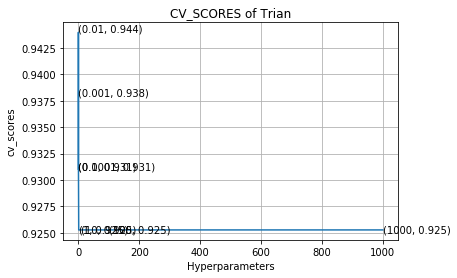

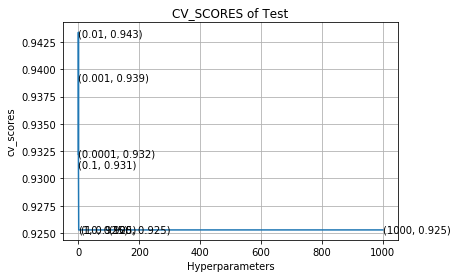

************************************************************************************************************************
-------------------- Confusion matrix --------------------


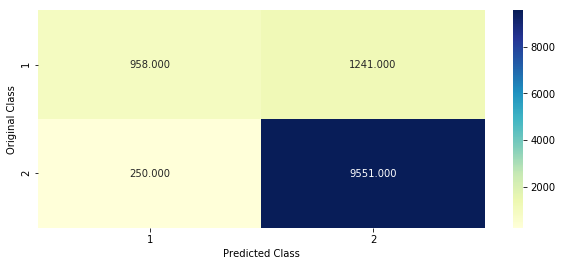


The accuracy of the LR [Test data] for lambda:  87.575

The precision of the LR [Test data] for lambda:  88.50074128984433

The recall of the LR [Test data] for lambda:  97.4492398734823
************************************************************************************************************************

The F1_score of the LR [Train data] for lambda:  94.53279272752766

The F1_score of the LR [Test data] for lambda:  92.75967561792842
--------------------------------------------------------------------------------
00:00:11


In [86]:
linear_grid_tfidfw2v = grid_linear_svm(train_std_tfidfw2v,test_std_tfidfw2v,y_1,y_test)

In [87]:
#rbf_grid_tfidfw2v = random_RBF_svm(train_std_tfidfw2v,test_std_tfidfw2v,y_1,y_test)

In [88]:
x = PrettyTable()

x.field_names = ["Vectorizer", "Kernel", "Accuracy", "Precision", "Recall", "F1_Score"]
x.add_row(["BOW", "Linear Kernel",91.9,92.70,98.33,95.43])
x.add_row(["BOW", "RBF Kernel",86.51,86.50,99.94,92.73])
x.add_row(["TFIDF", "Linear Kernel",91.93,92.47,98.66,95.47])
x.add_row(["TFIDF", "RBF Kernel",86.16,86.16,100,92.57])
x.add_row(["AVG-W2V", "Linear Kernel",88.26,88.40,99.41,93.59])
x.add_row(["AVG-W2V", "RBF Kernel",88.76,90.43,97.25,93.71])
x.add_row(["TFIDF-W2V", "Linear Kernel",89.4,90.13,98.47,94.12])
x.add_row(["TFIDF-W2V", "RBF Kernel",89.18,89.58,98.95,94.03])
print(x)

+------------+---------------+----------+-----------+--------+----------+
| Vectorizer |     Kernel    | Accuracy | Precision | Recall | F1_Score |
+------------+---------------+----------+-----------+--------+----------+
|    BOW     | Linear Kernel |   91.9   |    92.7   | 98.33  |  95.43   |
|    BOW     |   RBF Kernel  |  86.51   |    86.5   | 99.94  |  92.73   |
|   TFIDF    | Linear Kernel |  91.93   |   92.47   | 98.66  |  95.47   |
|   TFIDF    |   RBF Kernel  |  86.16   |   86.16   |  100   |  92.57   |
|  AVG-W2V   | Linear Kernel |  88.26   |    88.4   | 99.41  |  93.59   |
|  AVG-W2V   |   RBF Kernel  |  88.76   |   90.43   | 97.25  |  93.71   |
| TFIDF-W2V  | Linear Kernel |   89.4   |   90.13   | 98.47  |  94.12   |
| TFIDF-W2V  |   RBF Kernel  |  89.18   |   89.58   | 98.95  |  94.03   |
+------------+---------------+----------+-----------+--------+----------+
